In [1]:
import torch
import torch.nn as nn
import torchaudio
from torchvision import transforms as vis_transforms
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from config import *
import librosa.display as libdis
import IPython.display as ipd

torchaudio.set_audio_backend('sox_io')


/Users/somaf/Documents/python-environments/tp_project_env/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(



## Load In Model 

In [2]:
config = 'segmented' # 'no_aug' 'segmented' 'tp' 'augerino'
transform = 'NI' # 'NI' 'PS'
if config != 'no_aug': config = f"{config}/{transform}"
run_id = '1'
epoch = '49'
run_path = f"data_interpreter/{config}/run_{run_id}/"

In [3]:
model = config.model()
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


AttributeError: 'str' object has no attribute 'model'

## Data prep

In [6]:
genre = 'blues'
number = '00001'

music_path = f"data/{genre}/norm/{genre}.{number}.wav"
print(f"Loading in {music_path}")
wd, sr = torchaudio.load(music_path)
resampler = aud_transforms.Resample(sr, 16000)
audio = resampler(wd).squeeze()
# wd.shape
sr, audio.shape

Loading in data/blues/norm/blues.00001.wav


(22050, torch.Size([480214]))

In [7]:
dataset_params = dict(
        frames=256,
        bands=128,
        window_size=1024,
        hop_size=256,
        e0=1e-3
    )
mel_spec_transform = nn.Sequential(
                aud_transforms.MelSpectrogram(
                        sample_rate=16000,
                        n_mels=dataset_params["bands"],
                        n_fft=dataset_params["window_size"],
                        hop_length=dataset_params["hop_size"]
                ),
                # aud_transforms.AmplitudeToDB()
        )

In [8]:
def splitsongs(wd, overlap = 0.25):
    temp_X = []

    # Get the input song array size
    xshape = wd.shape[0]
    chunk = 48000 # min wave arr len is 478.912 --> 10 chunks without overlap
    offset = int(chunk*(1.-overlap))
    
    # Split the song and create new ones on windows
    spsong = [wd[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        if s.shape[0] != chunk:
            continue

        temp_X.append(s)

    return np.array(temp_X)


In [9]:
patches = splitsongs(audio[:478912])
print(type(patches))
print(len(patches))
mel_specs = [mel_spec_transform(patch) for patch in patches]

final_patches = torch.stack(mel_specs)

# lmao = mel_spec_transform(patches[0])
# mel_spec = mel_spec_transform(audio[:465984]) # 456 width
# patches = torch.split(mel_spec, 76, dim=1)
# final_patches = torch.stack(patches)
# lmao.shape

<class 'numpy.ndarray'>
12
<ipython-input-8-c6bd5038b9e8>:17: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array(temp_X)
<ipython-input-8-c6bd5038b9e8>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(temp_X)
/Users/somaf/Documents/python-environments/tp_project_env/lib/python3.8/site-packages/torch/functional.py:515: UserWarning: stft wi

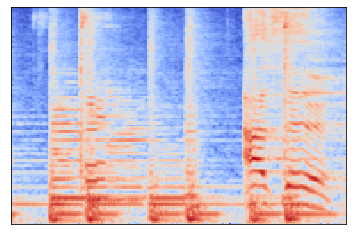

In [6]:
# final_patches.shape
libdis.specshow(final_patches[4,:,:].numpy())


In [76]:
loss = nn.CrossEntropyLoss()

In [77]:
temp_pred = torch.tensor([0, 0, 1])
temp_target = 2
loss(temp_pred, temp_target) 

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)